In [1]:
import json
import os
import numpy as np
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score, roc_curve
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

2025-04-19 20:40:54.275042: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-19 20:40:54.291146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745095254.311604    4005 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745095254.317780    4005 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-19 20:40:54.338149: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
SAVE_PATH = '/home/ec2-user/work/final_artifacts'
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

In [3]:
SEED = 0
BATCH_SIZE = 32
HEIGHT, WIDTH = 256, 256

---
### Classification model
Continuous target (between 0-1)

In [4]:
# https://www.kaggle.com/datasets/ninadaithal/imagesoasis
data_dir = kagglehub.dataset_download("ninadaithal/imagesoasis")
print("Path to dataset files:", data_dir)

Path to dataset files: /home/ec2-user/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1


In [5]:
labels, images = [], []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        file = os.path.join(root, file)
        if file.endswith('.jpg'):
            images.append(file)
            labels.append(file.split('/')[-2].replace(' ', ''))
del root, dirs, files, file, data_dir

In [6]:
df = pd.DataFrame({'images': images, 'labels': labels})
df = pd.concat([
    df[df['labels']=='ModerateDementia'],
    df[df['labels']=='MildDementia'],
    df[df['labels']=='VerymildDementia'],
    df[df['labels']=='NonDemented'].sample(n=25000, replace=False, random_state=SEED),
]).sample(frac=1., replace=False, random_state=SEED)
df_train_cls, df_test_cls = train_test_split(
    df, test_size=10000, shuffle=True, random_state=SEED, stratify=df['labels']
)
df_train_cls, df_val_cls = train_test_split(
    df_train_cls, test_size=10000, shuffle=True, random_state=SEED, stratify=df_train_cls['labels']
)
del df, labels, images

In [7]:
weights = df_train_cls['labels'].value_counts()
weights = weights.sum() / (weights.shape[0] * weights)
df_train_cls['weights'] = df_train_cls['labels'].map(weights)
df_val_cls['weights'] = df_val_cls['labels'].map(weights)
df_test_cls['weights'] = df_test_cls['labels'].map(weights)
del weights

In [8]:
def label_mapping(y):
    if y == 'NonDemented':
        return 0.
    if y == 'VerymildDementia':
        return 1/3
    if y == 'MildDementia':
        return 2/3
    if y == 'ModerateDementia':
        return 1.
    raise KeyError
def label_mapping_inv(y):
    if 0. <= y < 0.25:
        return 'NonDemented'
    if 0.25 <= y < 0.5:
        return 'VerymildDementia'
    if 0.5 <= y < 0.75:
        return 'MildDementia'
    if 0.75 <= y <= 1.:
        return 'ModerateDementia'
    raise KeyError

In [9]:
df_train_cls['labels'] = df_train_cls['labels'].apply(label_mapping)
df_val_cls['labels'] = df_val_cls['labels'].apply(label_mapping)
df_test_cls['labels'] = df_test_cls['labels'].apply(label_mapping)

In [10]:
def datagen_cls(df):
    return ImageDataGenerator(
        rotation_range=0.,
        width_shift_range=0.,
        height_shift_range=0.,
        shear_range=0.,
        zoom_range=0.,
        channel_shift_range=0.,
        horizontal_flip=False,
        vertical_flip=False,
        validation_split=0.,
        rescale=1/255,
        fill_mode='constant',
        cval=0.,
    ).flow_from_dataframe(
        df,
        x_col='images',
        y_col='labels',
        weight_col='weights',
        class_mode='raw',
        color_mode='rgb',
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=SEED,
    )

In [11]:
train_datagen_cls = datagen_cls(df_train_cls)
val_datagen_cls = datagen_cls(df_val_cls)
test_datagen_cls = datagen_cls(df_test_cls)

Found 24215 validated image filenames.
Found 10000 validated image filenames.
Found 10000 validated image filenames.


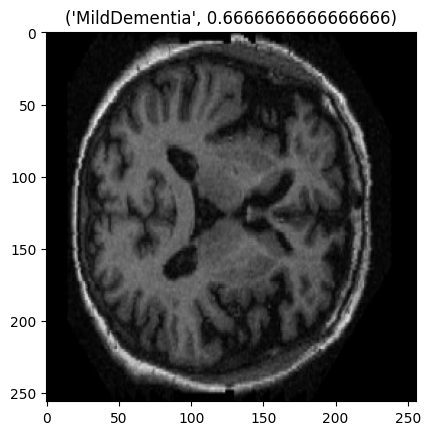

In [12]:
imgs = next(iter(train_datagen_cls))

i = 0
plt.imshow(imgs[0][i])
plt.title((label_mapping_inv(imgs[1][i]), float(imgs[1][i])))
plt.show()

del imgs

In [13]:
class Pooling(tf.keras.layers.Layer):
    def __init__(self, name='pooling', **kwargs):
        super().__init__(name=name, **kwargs)
    def build(self, input_shape):
        self.weight = self.add_weight(name='w', shape=(), initializer='ones')
        self.bias = self.add_weight(name='w', shape=(), initializer='zeros')
    def call(self, inputs):
        shape = tf.shape(inputs)
        new_shape = (shape[0], tf.math.reduce_prod(shape[1:]) )
        inputs = tf.reshape(inputs, new_shape)
        inputs_mean = tf.reduce_mean(inputs, axis=1, keepdims=True)
        outputs = inputs_mean*self.weight + self.bias
        return outputs

def unet_pool(base_model, input_size=(256, 256, 3)):
    inputs = Input(input_size)
    x = base_model(inputs)
    p = Pooling()(x)
    model = Model(inputs, p)
    return model

In [14]:
def categorical_accuracy(y_true, y_pred, weights=None):
    if weights is None:
        weights = np.ones_like(y_true)
    y_true = [label_mapping_inv(y) for y in y_true]
    y_pred = [label_mapping_inv(y) for y in y_pred]
    return accuracy_score(y_true, y_pred, sample_weight=weights)
def binary_accuracy(y_true, y_pred, weights=None):
    if weights is None:
        weights = np.ones_like(y_true)
    y_true = [label_mapping_inv(y)!='NonDemented' for y in y_true]
    y_pred = [label_mapping_inv(y)!='NonDemented' for y in y_pred]
    return accuracy_score(y_true, y_pred, sample_weight=weights)

In [15]:
model_seg = tf.keras.models.load_model(os.path.join(SAVE_PATH, 'trained_model_seg.keras'))
model_cls = unet_pool(model_seg, input_size=(HEIGHT, WIDTH, 3))
del model_seg

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(SAVE_PATH, 'model_cls_1.keras'), monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
]
metrics = [
    tf.keras.metrics.MeanSquaredLogarithmicError(),
    # categorical_accuracy, binary_accuracy,
]

model_cls.compile(optimizer=optim, loss=loss_fn, metrics=metrics)

I0000 00:00:1744484475.538627    8064 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13762 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5
/opt/tensorflow/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 90 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [16]:
history_cls = model_cls.fit(
    train_datagen_cls,
    # steps_per_epoch=df_train_cls.shape[0]//BATCH_SIZE,
    epochs=100,
    verbose=1,
    callbacks=callbacks,
    validation_data=val_datagen_cls,
    # validation_steps=df_val_cls.shape[0]//BATCH_SIZE,
)

Epoch 1/100


/opt/tensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744484482.780606    8215 service.cc:148] XLA service 0x7f591801d990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744484482.780643    8215 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-04-12 19:01:22.933649: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744484483.696564    8215 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-04-12 19:01:24.317919: I external/local_xla/xla/service/gpu/autotu

623/757 ━━━━━━━━━━━━━━━━━━━━ 2:46 1s/step - loss: 0.8336 - mean_squared_logarithmic_error: 0.0602

2025-04-12 19:15:42.489766: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[23,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,3,256,256]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-12 19:15:42.536482: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[23,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,64,256,256]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

757/757 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.7911 - mean_squared_logarithmic_error: 0.0607

2025-04-12 19:19:35.648699: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-12 19:19:35.710064: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,128,128]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBias

757/757 ━━━━━━━━━━━━━━━━━━━━ 1262s 2s/step - loss: 0.7908 - mean_squared_logarithmic_error: 0.0607 - val_loss: 0.4880 - val_mean_squared_logarithmic_error: 0.0623
Epoch 2/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 1067s 1s/step - loss: 0.4460 - mean_squared_logarithmic_error: 0.0580 - val_loss: 1.0365 - val_mean_squared_logarithmic_error: 0.7327
Epoch 3/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 1066s 1s/step - loss: 0.4348 - mean_squared_logarithmic_error: 0.0586 - val_loss: 2.4622 - val_mean_squared_logarithmic_error: 0.0605
Epoch 4/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 1068s 1s/step - loss: 0.4112 - mean_squared_logarithmic_error: 0.0539 - val_loss: 0.3968 - val_mean_squared_logarithmic_error: 0.0544
Epoch 5/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 1069s 1s/step - loss: 0.3889 - mean_squared_logarithmic_error: 0.0514 - val_loss: 0.3896 - val_mean_squared_logarithmic_error: 0.0527
Epoch 6/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 1067s 1s/step - loss: 0.3836 - mean_squared_logarithmic_error: 0.0517 - val_loss: 0.3963 - val_m

In [17]:
model_cls.save(os.path.join(SAVE_PATH, 'trained_model_cls_1.keras'))

In [17]:
with open(os.path.join(SAVE_PATH, 'history_cls_1.json'), 'w') as outfile:
    json.dump(history_cls.history, outfile)

Training curves

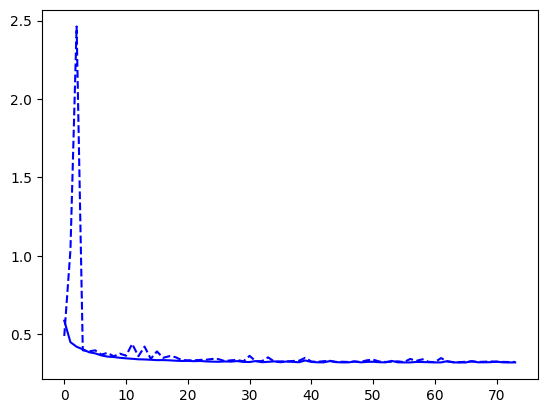

In [19]:
plt.plot(history_cls.history['loss'], 'b-', label='Train Loss')
plt.plot(history_cls.history['val_loss'], 'b--', label='Val Loss')
plt.show()

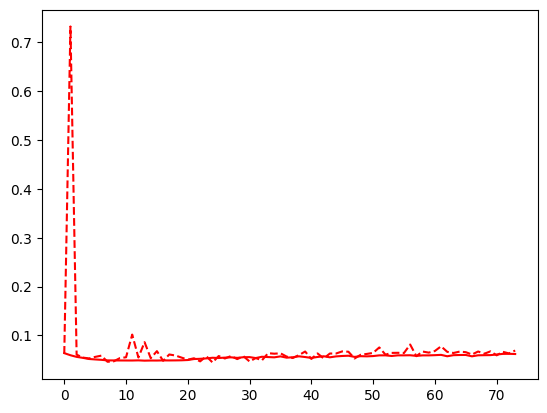

In [23]:
plt.plot(history_cls.history['mean_squared_logarithmic_error'], 'r-', label='Train MSLE')
plt.plot(history_cls.history['val_mean_squared_logarithmic_error'], 'r--', label='Val MSLE')
plt.show()

In [ ]:
# plt.plot(history_seg.history['binary_accuracy'], 'r-', label='Train Accuracy (b)')
# plt.plot(history_cls.history['categorical_accuracy'], 'b-', label='Train Accuracy (c)')
# plt.plot(history_cls.history['val_binary_accuracy'], 'r--', label='Train Accuracy (b)')
# plt.plot(history_cls.history['val_categorical_accuracy'], 'b--', label='Train Accuracy (c)')
# plt.show()

Validation set

In [18]:
true_score, pred_score = [], []
for idx, (img, lab, wgt) in enumerate(val_datagen_cls):
    true_score.extend(lab)
    score = tf.sigmoid(model_cls.predict(img, verbose=0))
    pred_score.extend(score)
    if idx == len(val_datagen_cls)-1:
        break
true_score = np.array(true_score).flatten()
pred_score = np.array(pred_score).flatten()

I0000 00:00:1744757328.397824   13027 service.cc:148] XLA service 0x7f62c400fc20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744757328.397850   13027 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-04-15 22:48:48.423813: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744757328.519456   13027 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-04-15 22:48:48.942132: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activa

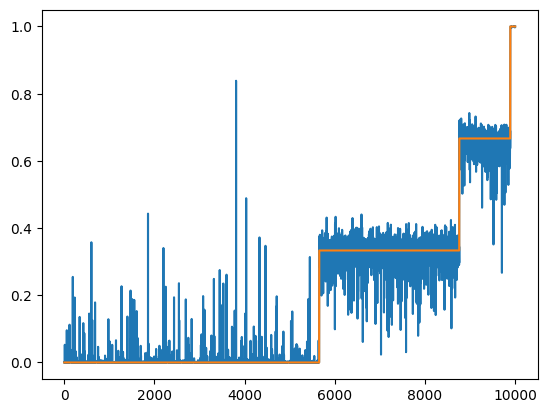

In [19]:
idx = true_score.argsort()
plt.plot(pred_score[idx])
plt.plot(true_score[idx])
plt.show()

In [20]:
true_lab = np.array([label_mapping_inv(y) for y in true_score])
pred_lab = np.array([label_mapping_inv(y) for y in pred_score])

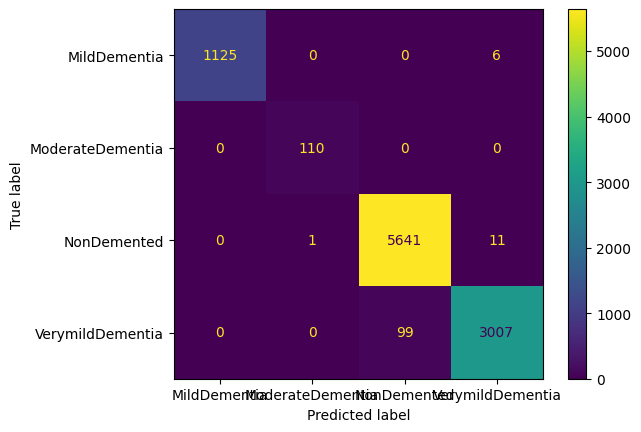

In [21]:
ConfusionMatrixDisplay.from_predictions(y_true=true_lab, y_pred=pred_lab);

Test/holdout set

In [229]:
true_score, pred_score = [], []
for idx, (img, lab, wgt) in enumerate(test_datagen_cls):
    true_score.extend(lab)
    pred = tf.sigmoid(model_cls.predict(img, verbose=0))
    pred_score.extend(pred)
    if idx == len(test_datagen_cls)-1:
        break
true_score = np.array(true_score).flatten()
pred_score = np.array(pred_score).flatten()

2025-04-15 23:41:56.505398: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-15 23:41:56.566900: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,256,256]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

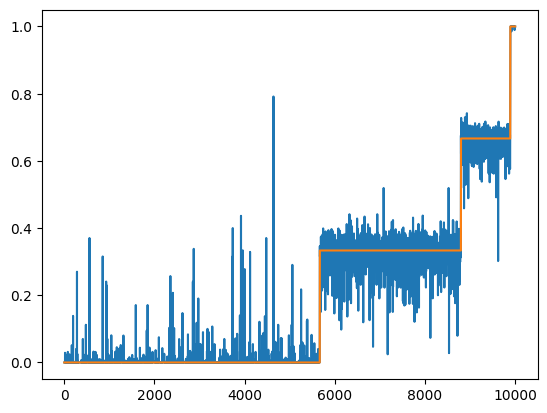

In [230]:
idx = true_score.argsort()
plt.plot(pred_score[idx])
plt.plot(true_score[idx])
plt.show()

In [231]:
true_lab = np.array([label_mapping_inv(y) for y in true_score])
pred_lab = np.array([label_mapping_inv(y) for y in pred_score])

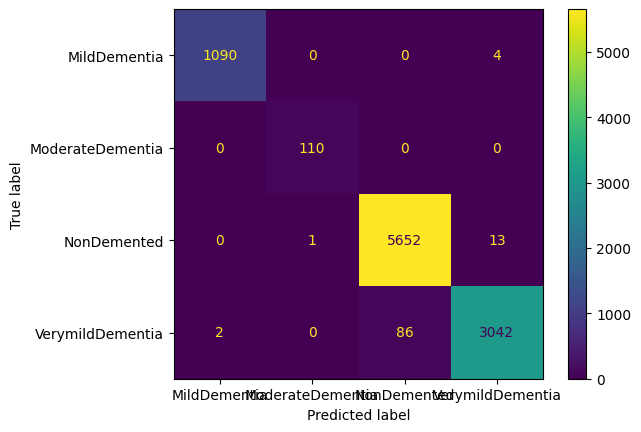

In [232]:
ConfusionMatrixDisplay.from_predictions(y_true=true_lab, y_pred=pred_lab);

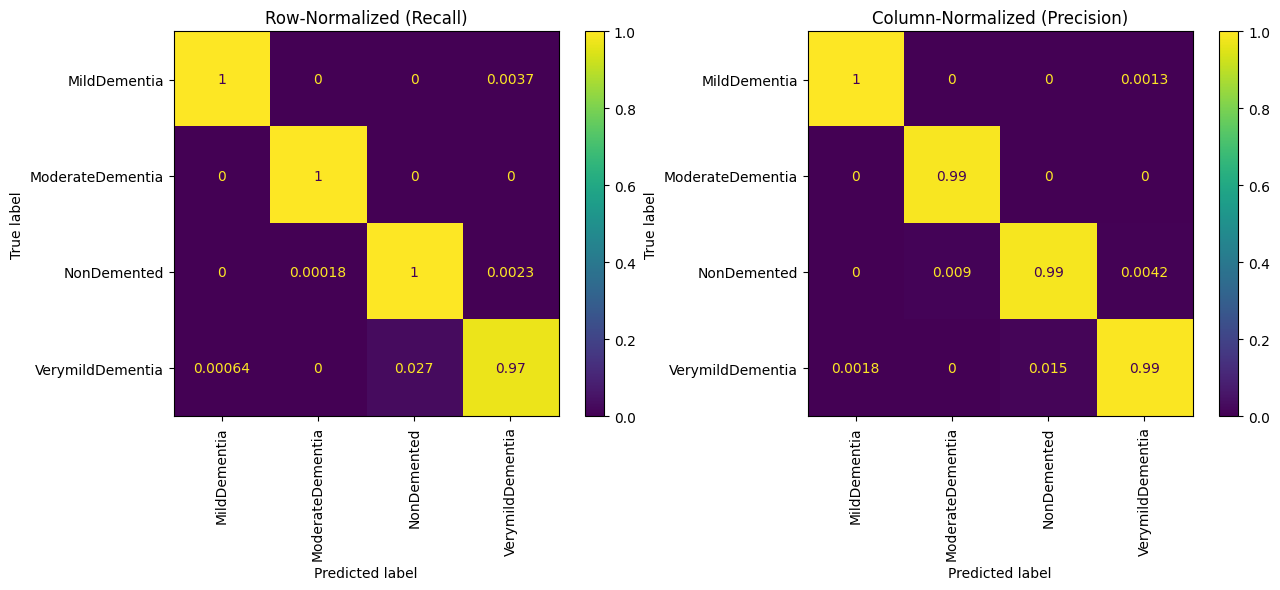

In [233]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ConfusionMatrixDisplay.from_predictions(
    y_true=true_lab, y_pred=pred_lab,
    im_kw=dict(vmin=0, vmax=1),
    xticks_rotation='vertical', ax=axes[0], normalize='true')
axes[0].set_title('Row-Normalized (Recall)')
ConfusionMatrixDisplay.from_predictions(
    y_true=true_lab, y_pred=pred_lab,
    im_kw=dict(vmin=0, vmax=1),
    xticks_rotation='vertical', ax=axes[1], normalize='pred')
axes[1].set_title('Column-Normalized (Precision)')
plt.show()

In [234]:
accuracy_score(true_lab, pred_lab), f1_score(true_lab, pred_lab, average='macro')

(0.9894, 0.9917489841843884)

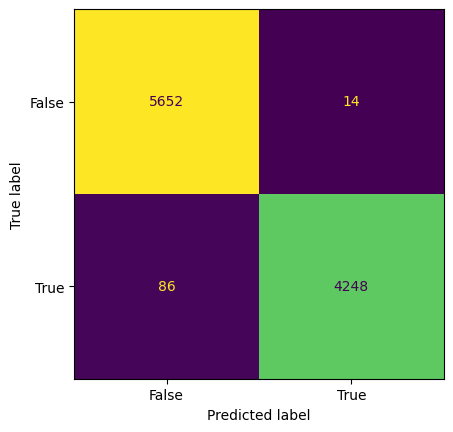

In [235]:
ConfusionMatrixDisplay.from_predictions(
    y_true=true_lab!='NonDemented', y_pred=pred_lab!='NonDemented', colorbar=False);

In [236]:
accuracy_score(true_lab!='NonDemented', pred_lab!='NonDemented'), \
f1_score(true_lab!='NonDemented', pred_lab!='NonDemented', average='macro')

(0.99, 0.989798914571867)

---
### Explainability

In [14]:
model_cls = tf.keras.models.load_model(
    os.path.join(SAVE_PATH, 'trained_model_cls_1.keras'), 
    custom_objects={'Pooling': Pooling},
)

I0000 00:00:1745079109.087961   69038 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13762 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


In [15]:
def explainability(img, model):
    seg = model.layers[1](img)
    cls = model.layers[2](seg)
    # seg = tf.sigmoid(seg*model.layers[-1].weight + model.layers[-1].bias)
    cls = tf.sigmoid(cls)
    return seg.numpy().squeeze(), cls.numpy().squeeze()

In [26]:
imgs = next(iter(test_datagen_cls))

In [27]:
i = np.where(imgs[1]>imgs[1].max()-1e-4)[0][0]
out = explainability(imgs[0][[i],:,:,:], model_cls)

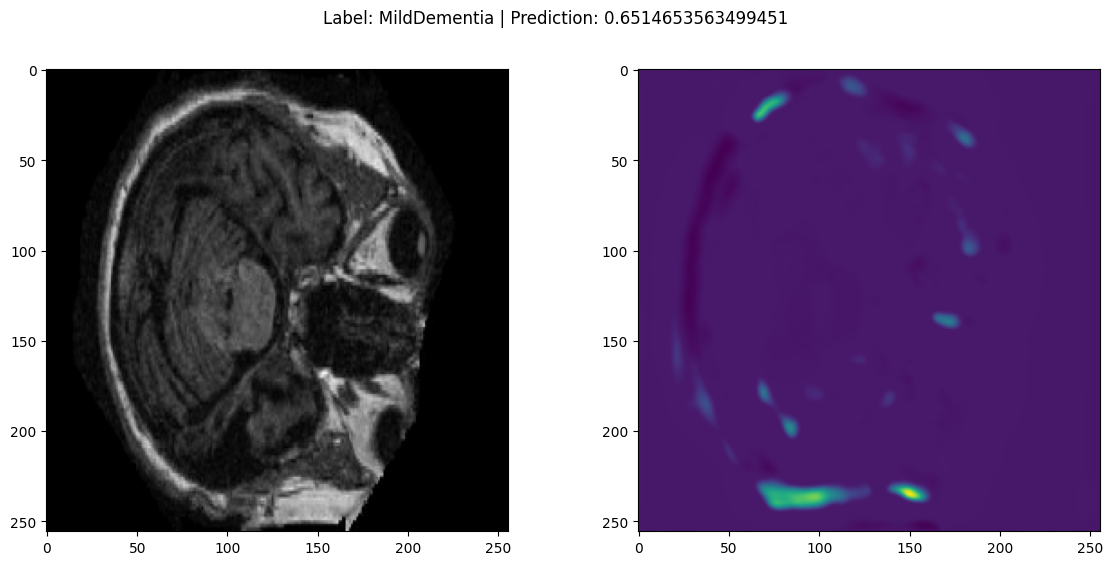

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
fig.suptitle(f'Label: {label_mapping_inv(imgs[1][i])} | Prediction: {out[1]}')
axes[0].imshow(imgs[0][i])
axes[1].imshow(out[0])
plt.show()

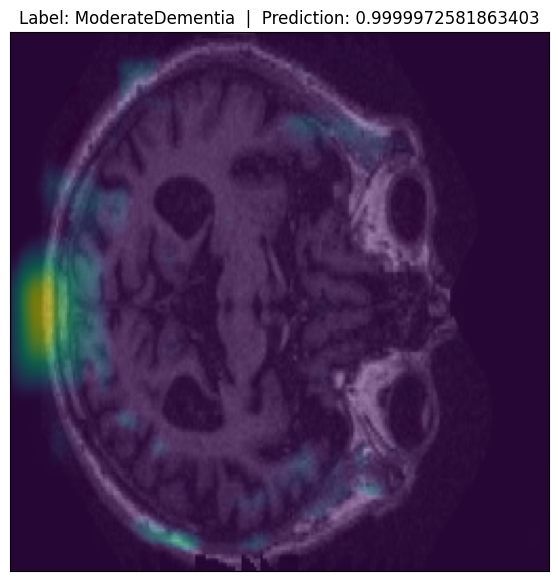

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
ax.set_title(f'Label: {label_mapping_inv(imgs[1][i])}  |  Prediction: {out[1]}')
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(imgs[0][i])
ax.imshow(out[0], alpha=0.55)
plt.show()